In [ ]:
# V2 Full Pipeline Integration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("V2 Full Pipeline Integration")
print("=" * 60)
print("Stage 1: Linear Regression + Log Transform (saved model)")
print("Stage 2: Random Forest (saved model)")
print("Stage 3: ESI Formula-based")
print("=" * 60)

V2 Full Pipeline Integration
Stage 1: Linear Regression + Log Transform (saved model)
Stage 2: Random Forest (saved model)
Stage 3: ESI Formula-based


In [ ]:
df = pd.read_csv('../data/Exoplanet_Dataset.csv')
print(f"Total exoplanets in dataset: {len(df)}")

stage1_cols = ['radius', 'orbital_period', 'star_mass', 'mass']
df_stage1 = df[stage1_cols].dropna()
print(f"\nStage 1 data (mass prediction): {len(df_stage1)} rows")

stage2_cols = ['star_teff', 'semi_major_axis', 'temp_calculated']
df_stage2 = df[stage2_cols].dropna()
print(f"Stage 2 data (temp prediction):  {len(df_stage2)} rows")

all_cols = ['radius', 'orbital_period', 'star_mass', 
            'star_teff', 'semi_major_axis', 
            'mass', 'temp_calculated']
df_full = df[all_cols].dropna()
print(f"Full pipeline data (all cols):   {len(df_full)} rows")

Total exoplanets in dataset: 5986

Stage 1 data (mass prediction): 1521 rows
Stage 2 data (temp prediction):  1881 rows
Full pipeline data (all cols):   973 rows


In [ ]:

stage1_model = joblib.load('../models/stage1_V2_lr_log.pkl')   # log-transform LR
stage2_model = joblib.load('../models/stage2_FINAL_model.pkl')  # Random Forest

print("=" * 60)
print("SAVED MODELS LOADED")
print("=" * 60)
print(f"\nStage 1: {type(stage1_model).__name__}")
print(f"  File: stage1_V2_lr_log.pkl")
print(f"  IMPORTANT: Trained on log1p(mass) -> predict gives LOG scale")
print(f"  Must apply np.expm1() to get original mass")
print(f"\nStage 2: {type(stage2_model).__name__}")
print(f"  File: stage2_FINAL_model.pkl")

SAVED MODELS LOADED

Stage 1: LinearRegression
  File: stage1_V2_lr_log.pkl
  IMPORTANT: Trained on log1p(mass) -> predict gives LOG scale
  Must apply np.expm1() to get original mass

Stage 2: RandomForestRegressor
  File: stage2_FINAL_model.pkl


In [ ]:
X_s1 = df_stage1[['radius', 'orbital_period', 'star_mass']]
y_s1 = df_stage1['mass']

X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(
    X_s1, y_s1, test_size=0.2, random_state=42
)

y_s1_pred_log = stage1_model.predict(X_s1_test)
y_s1_pred = np.expm1(y_s1_pred_log) 

negative_count = np.sum(y_s1_pred < 0)
y_s1_pred = np.maximum(y_s1_pred, 1e-6)

r2_s1 = r2_score(y_s1_test, y_s1_pred)
mae_s1 = mean_absolute_error(y_s1_test, y_s1_pred)
rmse_s1 = np.sqrt(mean_squared_error(y_s1_test, y_s1_pred))

y_s1_test_log = np.log1p(y_s1_test)
r2_s1_log = r2_score(y_s1_test_log, y_s1_pred_log)

print("=" * 60)
print("STAGE 1: Mass Prediction (V2 Log Transform)")
print("=" * 60)
print(f"Model: Linear Regression (trained on log1p(mass))")
print(f"Data: {len(df_stage1)} total, {len(X_s1_test)} test samples")
print(f"\nLog-scale R²:      {r2_s1_log:.4f}")
print(f"Original-scale R²: {r2_s1:.4f}")
print(f"Original-scale MAE: {mae_s1:.4f} Jupiter masses")
print(f"Original-scale RMSE: {rmse_s1:.4f} Jupiter masses")
print(f"Negative predictions handled: {negative_count}")

print(f"\nSanity Check:")
print(f"  Actual mass range:    [{y_s1_test.min():.4f}, {y_s1_test.max():.4f}]")
print(f"  Predicted mass range: [{y_s1_pred.min():.4f}, {y_s1_pred.max():.4f}]")
print(f"  Actual mean:    {y_s1_test.mean():.4f}")
print(f"  Predicted mean: {y_s1_pred.mean():.4f}")

STAGE 1: Mass Prediction (V2 Log Transform)
Model: Linear Regression (trained on log1p(mass))
Data: 1521 total, 305 test samples

Log-scale R²:      0.3173
Original-scale R²: 0.1133
Original-scale MAE: 0.6122 Jupiter masses
Original-scale RMSE: 1.3774 Jupiter masses
Negative predictions handled: 19

Sanity Check:
  Actual mass range:    [0.0013, 10.3900]
  Predicted mass range: [0.0000, 3.6876]
  Actual mean:    0.7362
  Predicted mean: 0.6027


In [ ]:
X_s2 = df_stage2[['star_teff', 'semi_major_axis']]
y_s2 = df_stage2['temp_calculated']

X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(
    X_s2, y_s2, test_size=0.2, random_state=42
)

y_s2_pred = stage2_model.predict(X_s2_test)

r2_s2 = r2_score(y_s2_test, y_s2_pred)
mae_s2 = mean_absolute_error(y_s2_test, y_s2_pred)
rmse_s2 = np.sqrt(mean_squared_error(y_s2_test, y_s2_pred))

print("=" * 60)
print("STAGE 2: Temperature Prediction (Random Forest)")
print("=" * 60)
print(f"Data: {len(df_stage2)} total, {len(X_s2_test)} test samples")
print(f"\nR²:   {r2_s2:.4f}")
print(f"MAE:  {mae_s2:.2f} K")
print(f"RMSE: {rmse_s2:.2f} K")

print(f"\nSanity Check:")
print(f"  Actual temp range:    [{y_s2_test.min():.1f}, {y_s2_test.max():.1f}] K")
print(f"  Predicted temp range: [{y_s2_pred.min():.1f}, {y_s2_pred.max():.1f}] K")

STAGE 2: Temperature Prediction (Random Forest)
Data: 1881 total, 377 test samples

R²:   0.8465
MAE:  117.80 K
RMSE: 206.79 K

Sanity Check:
  Actual temp range:    [123.0, 3921.0] K
  Predicted temp range: [167.1, 2414.3] K


In [ ]:
def calculate_esi_component(x, x_earth):
    """ESI component: 1 - |x - x_earth| / (x + x_earth)"""
    x = np.where(x <= 0, 1e-6, x)
    denominator = np.where((x + x_earth) == 0, 1e-6, x + x_earth)
    esi = 1 - np.abs(x - x_earth) / denominator
    return np.clip(esi, 0, 1)

def calculate_esi(radius, mass, temperature):
    """
    ESI = (esi_radius^0.57) * (esi_mass^0.23) * (esi_temp^0.20)
    
    radius: Earth radii
    mass: Earth masses
    temperature: Kelvin
    """
    EARTH_RADIUS = 1.0
    EARTH_MASS = 1.0
    EARTH_TEMP = 288.0
    
    esi_r = calculate_esi_component(radius, EARTH_RADIUS)
    esi_m = calculate_esi_component(mass, EARTH_MASS)
    esi_t = calculate_esi_component(temperature, EARTH_TEMP)
    
    esi = (esi_r ** 0.57) * (esi_m ** 0.23) * (esi_t ** 0.20)
    return np.clip(esi, 0, 1)

def classify_habitability(esi):
    """High >= 0.8, Moderate >= 0.5, Low < 0.5"""
    if isinstance(esi, (float, np.floating)):
        if esi >= 0.8: return "High"
        elif esi >= 0.5: return "Moderate"
        else: return "Low"
    return np.where(esi >= 0.8, "High", np.where(esi >= 0.5, "Moderate", "Low"))

# Sanity check
earth_esi = calculate_esi(radius=1.0, mass=1.0, temperature=288.0)
print(f"ESI Sanity Check: Earth ESI = {earth_esi:.6f} (expected 1.0)")
print("ESI functions ready.")

ESI Sanity Check: Earth ESI = 1.000000 (expected 1.0)
ESI functions ready.


In [ ]:
df_full_train, df_full_test = train_test_split(
    df_full, test_size=0.2, random_state=42
)

print("=" * 60)
print("FULL PIPELINE EVALUATION (Test Set Only)")
print("=" * 60)
print(f"Total: {len(df_full)} | Train: {len(df_full_train)} | Test: {len(df_full_test)}")

actual_radius = df_full_test['radius'].values
actual_mass = df_full_test['mass'].values
actual_temp = df_full_test['temp_calculated'].values

esi_actual = calculate_esi(actual_radius, actual_mass, actual_temp)
hab_actual = classify_habitability(esi_actual)

print(f"\nESI Statistics (Actual - Test Set):")
print(f"  Mean:   {esi_actual.mean():.4f}")
print(f"  Median: {np.median(esi_actual):.4f}")
print(f"  Min:    {esi_actual.min():.4f}")
print(f"  Max:    {esi_actual.max():.4f}")

unique, counts = np.unique(hab_actual, return_counts=True)
print(f"\nHabitability Distribution (Actual):")
for label, count in zip(unique, counts):
    print(f"  {label}: {count} ({count/len(hab_actual)*100:.1f}%)")

FULL PIPELINE EVALUATION (Test Set Only)
Total: 973 | Train: 778 | Test: 195

ESI Statistics (Actual - Test Set):
  Mean:   0.4490
  Median: 0.4325
  Min:    0.1006
  Max:    0.8972

Habitability Distribution (Actual):
  High: 6 (3.1%)
  Low: 104 (53.3%)
  Moderate: 85 (43.6%)


In [ ]:
print("FULL PIPELINE: ML PREDICTIONS (Test Set)")
print("=" * 60)

# Stage 1: Mass prediction (log model -> expm1 inverse)
X_pipe_s1 = df_full_test[['radius', 'orbital_period', 'star_mass']]
pred_mass_log = stage1_model.predict(X_pipe_s1)
pred_mass = np.expm1(pred_mass_log)  # INVERSE TRANSFORM
pred_mass = np.maximum(pred_mass, 1e-6)

print("Stage 1: Mass Prediction")
print(f"  Model: LR + Log Transform")
print(f"  Predicted {len(pred_mass)} mass values")
print(f"  Range: [{pred_mass.min():.4f}, {pred_mass.max():.4f}] Jupiter masses")

# Stage 2: Temperature prediction
X_pipe_s2 = df_full_test[['star_teff', 'semi_major_axis']]
pred_temp = stage2_model.predict(X_pipe_s2)

print(f"\nStage 2: Temperature Prediction")
print(f"  Model: Random Forest")
print(f"  Predicted {len(pred_temp)} temperature values")
print(f"  Range: [{pred_temp.min():.1f}, {pred_temp.max():.1f}] K")

# Stage 3: ESI with predicted values (radius is actual - not predicted)
pred_radius = actual_radius
esi_predicted = calculate_esi(pred_radius, pred_mass, pred_temp)
hab_predicted = classify_habitability(esi_predicted)

print(f"\nStage 3: ESI Calculation")
print(f"\nESI Statistics (Predicted - Test Set):")
print(f"  Mean:   {esi_predicted.mean():.4f}")
print(f"  Median: {np.median(esi_predicted):.4f}")
print(f"  Min:    {esi_predicted.min():.4f}")
print(f"  Max:    {esi_predicted.max():.4f}")

unique_pred, counts_pred = np.unique(hab_predicted, return_counts=True)
print(f"\nHabitability Distribution (Predicted):")
for label, count in zip(unique_pred, counts_pred):
    print(f"  {label}: {count} ({count/len(hab_predicted)*100:.1f}%)")

FULL PIPELINE: ML PREDICTIONS (Test Set)
Stage 1: Mass Prediction
  Model: LR + Log Transform
  Predicted 195 mass values
  Range: [0.0000, 60.6908] Jupiter masses

Stage 2: Temperature Prediction
  Model: Random Forest
  Predicted 195 temperature values
  Range: [289.4, 2416.7] K

Stage 3: ESI Calculation

ESI Statistics (Predicted - Test Set):
  Mean:   0.5134
  Median: 0.5430
  Min:    0.0136
  Max:    0.8979

Habitability Distribution (Predicted):
  High: 21 (10.8%)
  Low: 85 (43.6%)
  Moderate: 89 (45.6%)


In [ ]:
print("PIPELINE ACCURACY COMPARISON")
print("=" * 60)

mass_log_r2 = r2_score(np.log1p(actual_mass), pred_mass_log)
mass_r2 = r2_score(actual_mass, pred_mass)
mass_mae = mean_absolute_error(actual_mass, pred_mass)
print(f"\nMass Prediction:")
print(f"  Log-scale R²:      {mass_log_r2:.4f}")
print(f"  Original-scale R²: {mass_r2:.4f}")
print(f"  Original-scale MAE: {mass_mae:.4f} Jupiter masses")

temp_r2 = r2_score(actual_temp, pred_temp)
temp_mae = mean_absolute_error(actual_temp, pred_temp)
print(f"\nTemperature Prediction:")
print(f"  R²:  {temp_r2:.4f}")
print(f"  MAE: {temp_mae:.2f} K")

esi_mae = mean_absolute_error(esi_actual, esi_predicted)
esi_corr = np.corrcoef(esi_actual, esi_predicted)[0, 1]
print(f"\nESI Score:")
print(f"  MAE:         {esi_mae:.4f}")
print(f"  Correlation: {esi_corr:.4f}")

hab_accuracy = accuracy_score(hab_actual, hab_predicted)
print(f"\nHabitability Classification:")
print(f"  Accuracy: {hab_accuracy:.4f} ({hab_accuracy*100:.1f}%)")

print(f"\nConfusion Matrix:")
labels = ['High', 'Moderate', 'Low']
cm = confusion_matrix(hab_actual, hab_predicted, labels=labels)
cm_df = pd.DataFrame(cm, index=[f'Actual {l}' for l in labels], 
                      columns=[f'Pred {l}' for l in labels])
print(cm_df)

PIPELINE ACCURACY COMPARISON (Test Set)

Mass Prediction:
  Log-scale R²:      0.2693  <- modelin gercek performansi
  Original-scale R²: -5.8783  <- expm1 sonrasi
  Original-scale MAE: 0.9840 Jupiter masses

Temperature Prediction:
  R²:  0.9343
  MAE: 92.11 K

ESI Score:
  MAE:         0.0997
  Correlation: 0.9013

Habitability Classification:
  Accuracy: 0.8205 (82.1%)

Confusion Matrix:
                 Pred High  Pred Moderate  Pred Low
Actual High              6              0         0
Actual Moderate         14             70         1
Actual Low               1             19        84


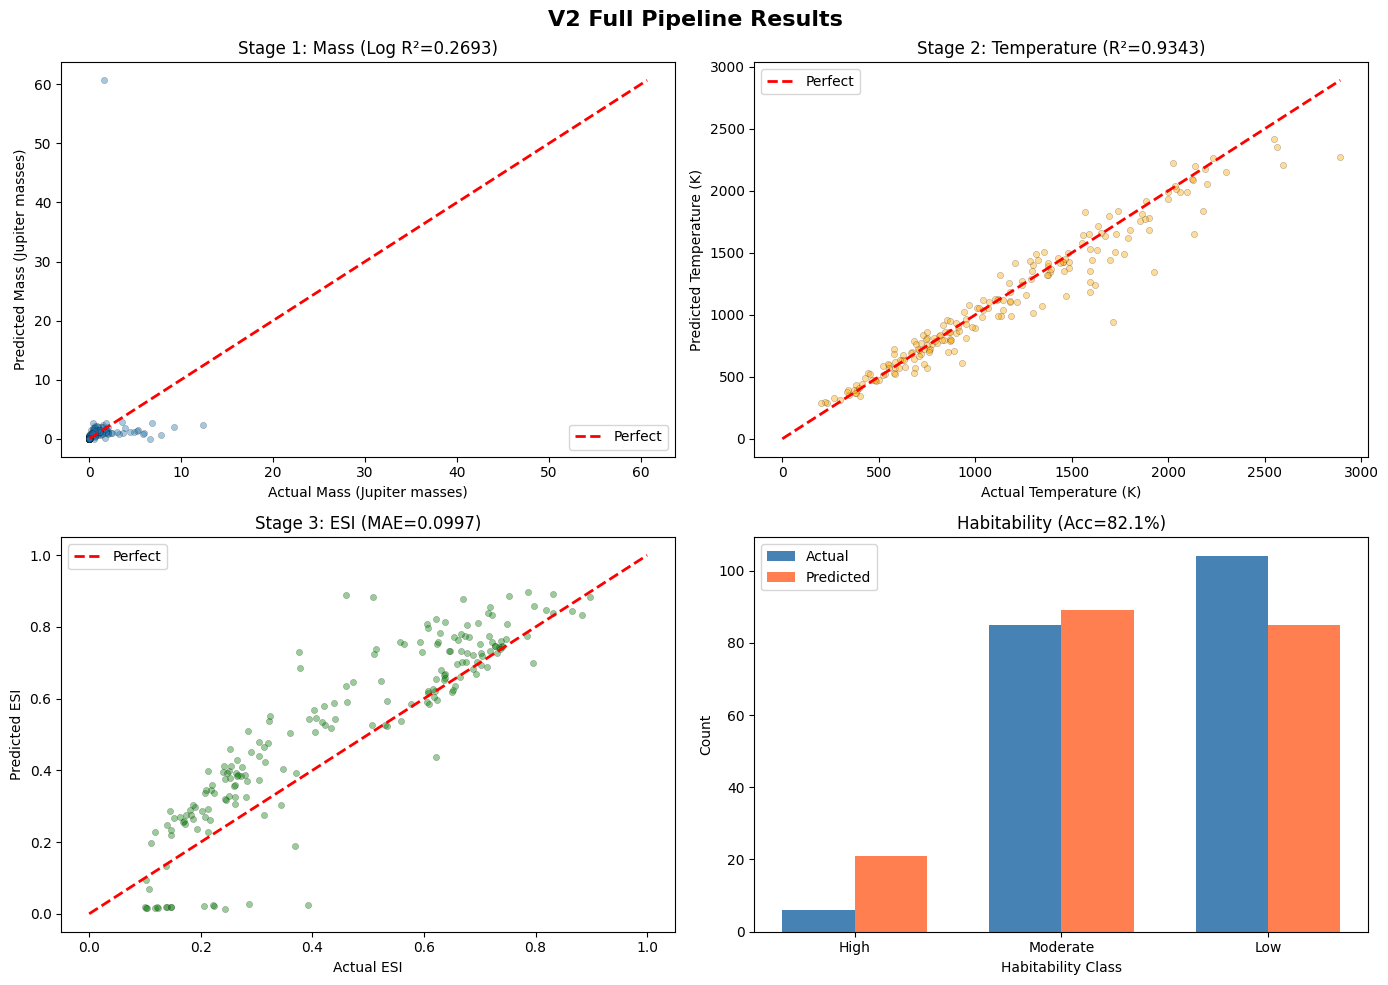

Figure saved: ../outputs/figures/v2_full_pipeline_results.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('V2 Full Pipeline Results', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
ax1.scatter(actual_mass, pred_mass, alpha=0.4, s=20, edgecolors='k', linewidths=0.3)
max_mass = max(actual_mass.max(), pred_mass.max())
ax1.plot([0, max_mass], [0, max_mass], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Mass (Jupiter masses)')
ax1.set_ylabel('Predicted Mass (Jupiter masses)')
ax1.set_title(f'Stage 1: Mass (Log R²={mass_log_r2:.4f})')
ax1.legend()

ax2 = axes[0, 1]
ax2.scatter(actual_temp, pred_temp, alpha=0.4, s=20, edgecolors='k', linewidths=0.3, color='orange')
max_temp = max(actual_temp.max(), pred_temp.max())
ax2.plot([0, max_temp], [0, max_temp], 'r--', lw=2, label='Perfect')
ax2.set_xlabel('Actual Temperature (K)')
ax2.set_ylabel('Predicted Temperature (K)')
ax2.set_title(f'Stage 2: Temperature (R²={temp_r2:.4f})')
ax2.legend()

ax3 = axes[1, 0]
ax3.scatter(esi_actual, esi_predicted, alpha=0.4, s=20, edgecolors='k', linewidths=0.3, color='green')
ax3.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect')
ax3.set_xlabel('Actual ESI')
ax3.set_ylabel('Predicted ESI')
ax3.set_title(f'Stage 3: ESI (MAE={esi_mae:.4f})')
ax3.legend()

ax4 = axes[1, 1]
labels_plot = ['High', 'Moderate', 'Low']
actual_counts = [np.sum(hab_actual == l) for l in labels_plot]
pred_counts = [np.sum(hab_predicted == l) for l in labels_plot]
x = np.arange(len(labels_plot))
width = 0.35
ax4.bar(x - width/2, actual_counts, width, label='Actual', color='steelblue')
ax4.bar(x + width/2, pred_counts, width, label='Predicted', color='coral')
ax4.set_xlabel('Habitability Class')
ax4.set_ylabel('Count')
ax4.set_title(f'Habitability (Acc={hab_accuracy*100:.1f}%)')
ax4.set_xticks(x)
ax4.set_xticklabels(labels_plot)
ax4.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/v2_full_pipeline_results.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved: ../outputs/figures/v2_full_pipeline_results.png")

In [ ]:
print("V2 FULL PIPELINE SUMMARY")
print("=" * 60)

print(f"""
Models Used:
  Stage 1: LinearRegression + log1p transform (stage1_V2_lr_log.pkl)
  Stage 2: RandomForest (stage2_FINAL_model.pkl)
  Stage 3: ESI formula-based

Pipeline Performance (Test Set: {len(df_full_test)} samples):
  Mass Log-scale R²:  {mass_log_r2:.4f}
  Mass Orig-scale R²: {mass_r2:.4f}
  Temperature R²:     {temp_r2:.4f}
  ESI MAE:            {esi_mae:.4f}
  Habitability Acc:   {hab_accuracy*100:.1f}%

Key Notes:
  - Stage 1 model predicts in LOG space -> np.expm1() required
  - Log-scale R² is the meaningful metric for mass (model trained in log space)
  - Original-scale R² is low because expm1() amplifies errors for large values
  - Pipeline evaluated on test set only (not train+test mixed)
""")

V2 FULL PIPELINE SUMMARY

Models Used:
  Stage 1: LinearRegression + log1p transform (stage1_V2_lr_log.pkl)
  Stage 2: RandomForest (stage2_FINAL_model.pkl)
  Stage 3: ESI formula-based

Pipeline Performance (Test Set: 195 samples):
  Mass Log-scale R²:  0.2693
  Mass Orig-scale R²: -5.8783
  Temperature R²:     0.9343
  ESI MAE:            0.0997
  Habitability Acc:   82.1%

Key Notes:
  - Stage 1 model predicts in LOG space -> np.expm1() required
  - Log-scale R² is the meaningful metric for mass (model trained in log space)
  - Original-scale R² is low because expm1() amplifies errors for large values
  - Pipeline evaluated on test set only (not train+test mixed)

